## Randomized Singular Value Decomposition
Erichson, N. B., Voronin, S., Brunton, S. L., & Kutz, J. N. (2016). Randomized matrix decompositions using R. arXiv preprint arXiv:1608.02148.

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/2024fall/BME574/Homework`


In [5]:
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/2024fall/BME574/Homework/Project.toml`
  No Changes to `~/2024fall/BME574/Homework/Manifest.toml`


In [2]:
using Images, Colors, LinearAlgebra, Plots, Random, BenchmarkTools, LinearAlgebra.BLAS

In [3]:
BLAS.set_num_threads(4)

In [4]:
img = load("dog.jpg");

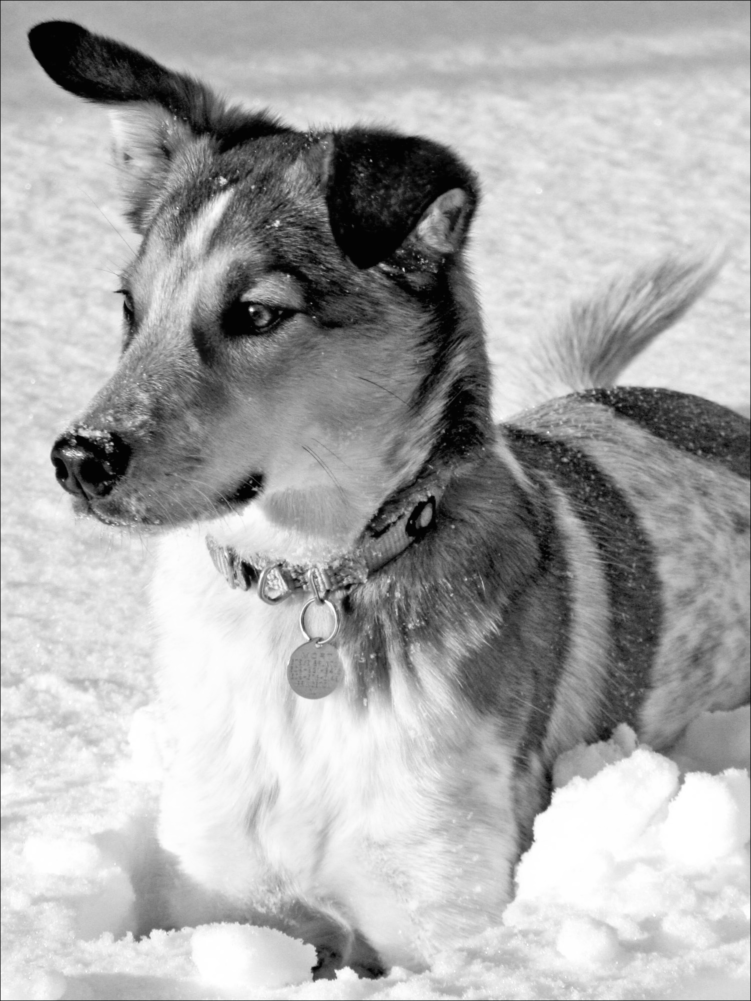

In [5]:
imgg = Gray.(img)

In [7]:
imga = Float64.(imgg);
size(imga)

(2000, 1500)

In [8]:
# Function to generate random test matrix based on distribution
function generate_random_matrix(n, l, sdist)
    if sdist == "normal"
        return randn(n, l)  # Standard normal distribution
    elseif sdist == "uniform"
        return rand(n, l) .* 2 .- 1  # Uniform in [-1, 1]
    elseif sdist == "rademacher"
        return rand([1, -1], n, l)  # Rademacher distribution
    else
        error("Unsupported sampling distribution. Choose from 'normal', 'uniform', or 'rademacher'.")
    end
end

# Randomized SVD Function
function randomized_svd(A, k; oversampling=10, power_iters=2, sdist="normal")
    """
    Perform randomized SVD on matrix A.
    Parameters:
        A: Input matrix (m x n)
        k: Target rank
        oversampling: Oversampling parameter (default 10)
        power_iters: Number of power iterations (default 2)
        sdist: Sampling distribution for random matrix ('normal', 'uniform', 'rademacher')
    Returns:
        U, Σ, V: Approximated singular value decomposition components
    """
    # Dimensions of A
    m, n = size(A)

    # Matrix flipping if wide
    flipped = false
    if m < n
        A = A'
        m, n = size(A)
        flipped = true
    end

    # Oversampling
    l = k + oversampling

    # Step 1: Generate random test matrix
    Ω = generate_random_matrix(n, l, sdist)

    # Step 2: Compute the sketch matrix
    Y = A * Ω

    # Step 3: Perform power iterations to improve the approximation
    for _ in 1:power_iters
        Y = A * (A' * Y)
    end

    # Step 4: Orthonormalize Y using QR decomposition
    Q, _ = qr(Y)

    # Step 5: Form the smaller matrix B
    B = Q' * A

    # Step 6: Perform deterministic SVD on B
    U_hat, Σ, V = svd(B)

    # Step 7: Compute the final U matrix
    U = Q * U_hat

    # Flip back if the matrix was transposed
    if flipped
        U, V = V, U
    end

    # Return the approximated SVD components
    return U[:, 1:k], Σ[1:k], V[:, 1:k] # otherwise the dimention would be l(k+oversampling) but not k
end


randomized_svd (generic function with 1 method)

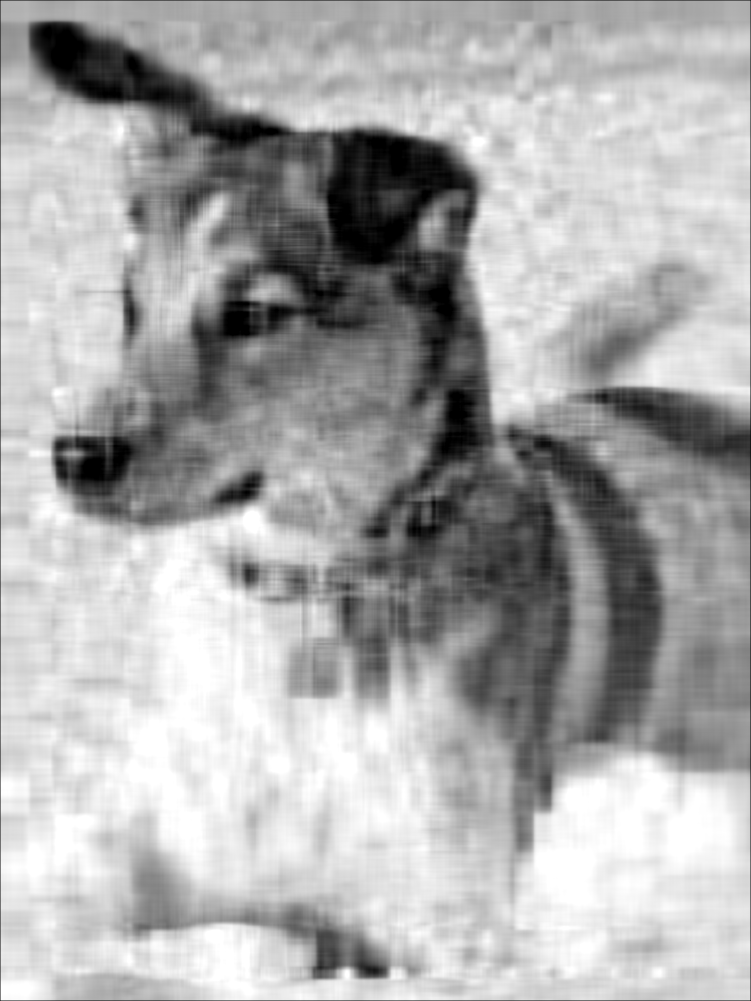

In [24]:
u,s,v = randomized_svd(imga,20)

Xapprox = u*Diagonal(s)*v'
imgc = Gray.(Xapprox)

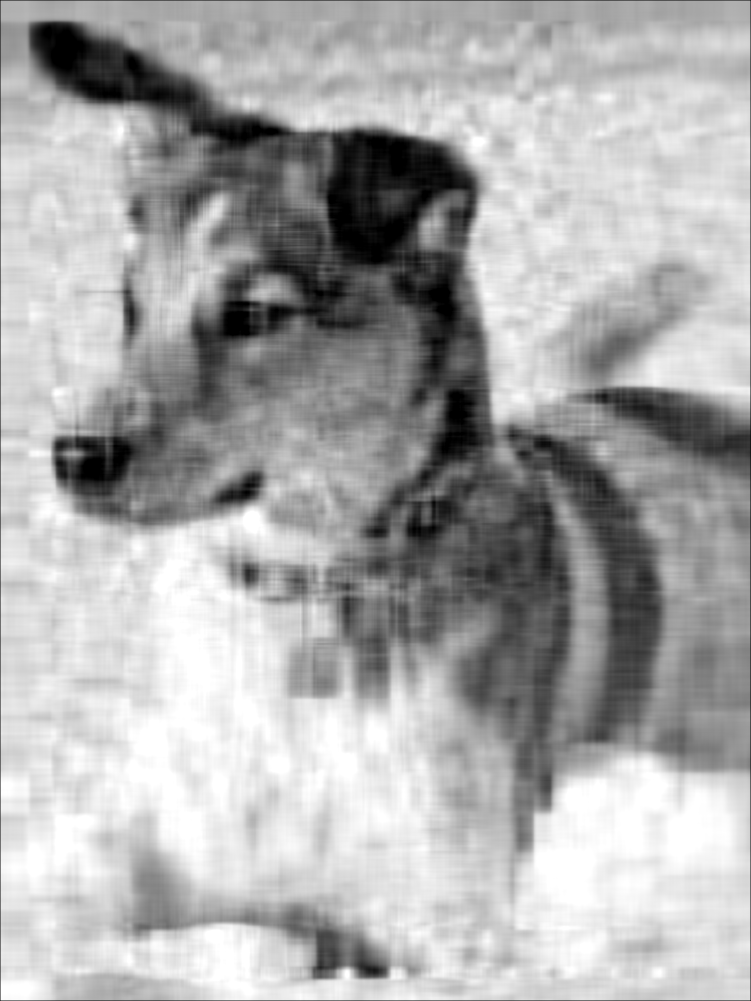

In [52]:
r=20
u,s,v = svd(imga)
Xapprox = u[:,1:r]*Diagonal(s[1:r])*v[:,1:r]'
imgc = Gray.(Xapprox)

In [59]:
@benchmark u,s,v = randomized_svd(imga,20)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  625.294 ms … 730.190 ms  ┊ GC (min … max): 0.00% … 14.37%
 Time  (median):     645.130 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   659.057 ms ±  33.455 ms  ┊ GC (mean ± σ):  2.06% ±  5.06%

  ▁     ▁  ▁ █              ▁  ▁                              ▁  
  █▁▁▁▁▁█▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  625 ms           Histogram: frequency by time          730 ms <

 Memory estimate: 164.51 MiB, allocs estimate: 46.

In [60]:
@benchmark u,s,v = randomized_svd(imga,50)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  654.621 ms … 748.533 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     663.059 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   677.091 ms ±  33.429 ms  ┊ GC (mean ± σ):  0.35% ± 0.63%

  █▁ ▁   ▁ ▁                       ▁                          ▁  
  ██▁█▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  655 ms           Histogram: frequency by time          749 ms <

 Memory estimate: 168.89 MiB, allocs estimate: 49.

In [61]:
@benchmark u,s,v = svd(imga)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  608.681 ms … 718.099 ms  ┊ GC (min … max): 0.00% … 15.09%
 Time  (median):     631.867 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   639.681 ms ±  35.137 ms  ┊ GC (mean ± σ):  2.12% ±  5.34%

  █         ▁ ▁█            ▁                                 ▁  
  █▁▁▁▁▁▁▁▁▁█▁██▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  609 ms           Histogram: frequency by time          718 ms <

 Memory estimate: 114.62 MiB, allocs estimate: 16.

In [62]:
# try a larger matrix?
m, n = 5000, 5000
A = randn(m, n);

In [63]:
@time u,s,v = randomized_svd(A,40);

 22.130526 seconds (51 allocations: 1.511 GiB, 0.08% gc time)


In [64]:
@time u,s,v = svd(A);

 22.166636 seconds (17 allocations: 1.118 GiB, 0.54% gc time)


In [55]:
function explained_variance_ratio(random_Σ, Σ)
    total_variance = sum(Σ.^2)  # Total variance (sum of squared singular values)
    retained_variance = sum(random_Σ.^2)  # Variance captured by top k singular values
    return retained_variance / total_variance
end

# Function to benchmark time & explained variance ratio
function benchmark_svd(matrix_sizes, percent_k; oversampling=10, power_iters=2)
    time_ratios = Float64[]  # Store the ratio of rSVD time to SVD time
    explained_variance_ratios = Float64[]

    for size in matrix_sizes
        # Create a random matrix of the given size
        A = randn(size, size)
        k = Int(size * percent_k)

        # # Time randomized SVD
        # time_rsvd = @elapsed randomized_svd(A, k, oversampling=oversampling, power_iters=power_iters)

        # # Time full SVD
        # time_svd = @elapsed svd(A)

        # Time and perform randomized SVD
        time_rsvd = @elapsed begin
            _, random_Σ, _ = randomized_svd(A, k, oversampling=oversampling, power_iters=power_iters)
        end

        # Time and perform full SVD
        time_svd = @elapsed begin
            _, full_Σ, _ = svd(A)
        end

        # Compute the time ratio
        push!(time_ratios, time_rsvd / time_svd)
        variance_ratio = explained_variance_ratio(random_Σ, full_Σ)
        push!(explained_variance_ratios, variance_ratio)
    end

    return time_ratios, explained_variance_ratios
end

benchmark_svd (generic function with 1 method)

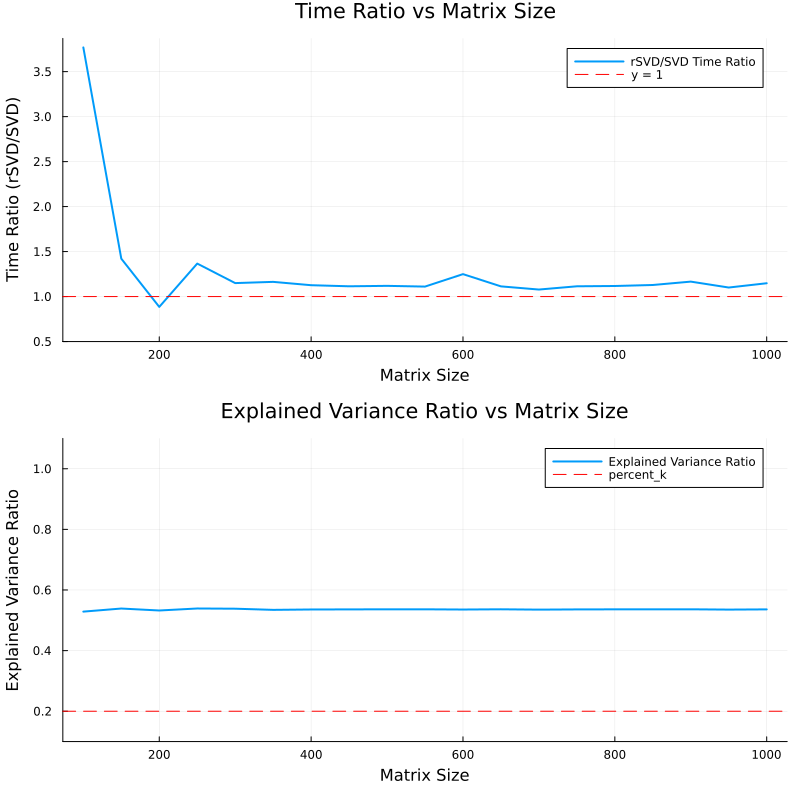

In [65]:
# Parameters
matrix_sizes = 100:50:1000  # Matrix sizes to test
percent_k = 0.2  # Target rank for randomized SVD

# Benchmark the SVD methods
time_ratios, explained_variance_ratios = benchmark_svd(matrix_sizes, percent_k)

# Create subplots to show both ratios
p1 = plot(matrix_sizes, time_ratios, xlabel="Matrix Size", ylabel="Time Ratio (rSVD/SVD)",
          title="Time Ratio vs Matrix Size", lw=2, ylim=(0.5, maximum(time_ratios) + 0.1),
          label="rSVD/SVD Time Ratio", legend=:topright)

# Add a dashed horizontal line at y=1
hline!(p1, [1], linestyle=:dash, color=:red, label="y = 1")

# Plot the explained variance ratio
p2 = plot(matrix_sizes, explained_variance_ratios, xlabel="Matrix Size",
          ylabel="Explained Variance Ratio", title="Explained Variance Ratio vs Matrix Size",
          lw=2, ylim=(0.1, 1.1), label="Explained Variance Ratio", legend=:topright)
hline!(p2, [percent_k], linestyle=:dash, color=:red, label = "percent_k")

# Combine the plots into one figure
plot(p1, p2, layout=(2, 1), size=(800, 800))
